In [6]:
import os
import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
# from otps import TimePoint
# from otps import predict_tide
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('/g/data/u46/users/sc0554/dea-notebooks/Scripts')
import DEAPlotting
import DEADataHandling

%load_ext autoreload
%autoreload 2

# Create datacube instance
dc = datacube.Datacube(app='Hattah lakes animation')

# def tidal_tag(ds):

#     # Extract list of datetimes based on Landsat time of acquisition for each image
#     observed_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()

#     # Set a tide post: this is the location the OTPS model uses to compute tides for the supplied datetimes
#     tidepost_lat, tidepost_lon = -18.2066466248, 122.214634558

#     # The OTPS model requires inputs as 'TimePoint' objects, which are combinations of lon-lat coordinates 
#     # and a datetime object. You can create a list of these with a list comprehension:
#     observed_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in observed_datetimes]

#     # Feed the entire list of timepoints to the OTPS `predict_tide` function:
#     observed_predictedtides = predict_tide(observed_timepoints)

#     # For each of the predicted tide objects, extract a list of tidal heights in `m` units relative to mean 
#     # sea level (the `tide_m` method should not be confused with the `depth_m` method, which gives you the 
#     # ocean depth at the tide post location that is used by the OTPS model to predict tides)
#     observed_tideheights = [predictedtide.tide_m for predictedtide in observed_predictedtides]

#     # Assign to dataset and filter by tides
#     ds['tide_heights'] = xr.DataArray(observed_tideheights, [('time', data.time)])
    
#     return ds


def interpolate_timeseries(ds):

    # Shift time series up by one timestep and take average
    ds_shifted = ds.shift(time=1)
    ds_mean = (ds + ds_shifted) / 2.0

    # Shift time stamps up by one and take average, then sub into new ds
    time_int = ds_mean.time.astype('i8')
    time_shift_int = ds_mean.time.shift(time=1).astype('i8')
    time_shift_int[0] = time_int[0]
    time_ave = ((time_int + time_shift_int) / 2.0).astype('datetime64[ns]')
    ds_mean.coords['time'] = time_ave

    # Combine old and new datasets, skipping single timestep with no data
    ds_all = xr.auto_combine([ds, ds_mean]).sortby('time')
    ds_all = ds_all.isel(time=[0, *range(2, len(ds_all.time))])
    
    return ds_all


## Import data

Loading ls5 PQ
    Loading 29 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 0 filtered ls7 timesteps
Loading ls8 PQ
    Loading 65 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


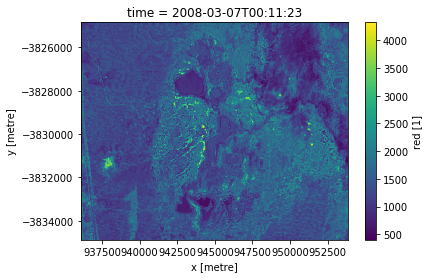

In [9]:
# Hattah Lakes
lat, lon, buffer, masked_prop, study_area = -34.7248797472, 142.364576034, 5000, 0.80, 'hattah'
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer * (1280/720.0), x + buffer * (1280/720.0)),
         'y': (y - buffer, y + buffer),         
         'crs': 'EPSG:3577',
         'time': ('2008-01-01', '2018-01-01')}

# Load in data
data = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart', 
                                        bands_of_interest=['red', 'green', 'blue', 'nir', 'swir1'],  # 'nir', 'swir1', 
                                        masked_prop=masked_prop, apply_mask=False)  
data.red.isel(time=0).plot()

## Interpolate and smooth using median

In [10]:
# Interpolate to add an extra timestep
data_interp = interpolate_timeseries(data)

# Take rolling median
data_median = data_interp.rolling(time=10, center=True, min_periods=1).median()

In [17]:
data_median.to_netcdf('hattah_median_interp.netcdf', format = 'NETCDF4')

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


## Animate output

Generating 187 frame animation
    Exporting animation to hattah_simple_false.mp4


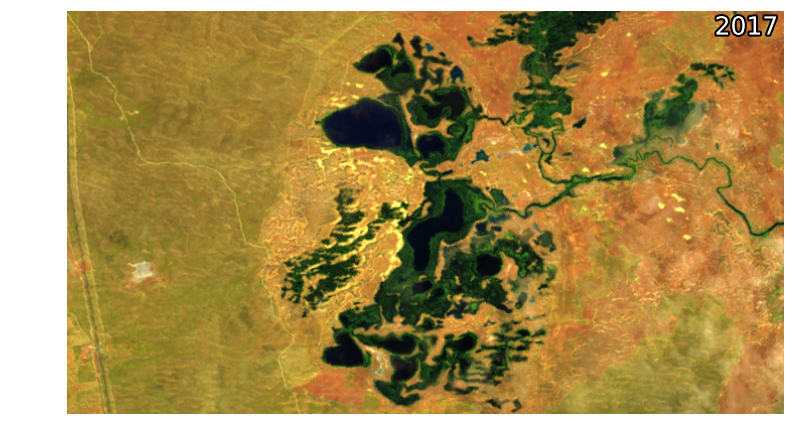

In [18]:
DEAPlotting.animated_timeseries(ds=data_median,
                    output_path='{}_simple_false.mp4'.format(study_area), 
                    bands=['swir1', 'nir', 'green'], 
                    interval=200,
                    show_date=False,
                    title=data_median.time.dt.year.values.tolist(),
                    width_pixels=500,
                    reflect_stand=4300)

## Extract time series

In [8]:
# Compute NDVI
ndvi = (data_median.nir - data_median.red) / (data_median.nir + data_median.red)
ndvi_timeseries = (ndvi > 0.45).mean(dim=['x', 'y'])
ndvi_timeseries.rolling(time=20, center=True, min_periods=1).mean().plot()

NameError: name 'data_median' is not defined

In [7]:
ndvi_df = ndvi_timeseries.rolling(time=20, center=True, min_periods=1).mean().to_dataframe(name='ndvi')

In [15]:
ndvi_df.to_csv('ndvi_df_hattah')

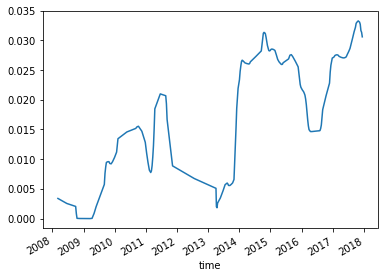

In [11]:
#Compute NDWI
ndwi = (data_median.green - data_median.nir) / (data_median.green + data_median.nir)
ndwi_timeseries = (ndwi > 0).mean(dim=['x', 'y'])
ndwi_timeseries.rolling(time=5, center=True, min_periods=1).mean().plot()

In [12]:
ndwi_df = ndwi_timeseries.rolling(time=5, center=True, min_periods=1).mean().to_dataframe(name='ndwi')

In [18]:
ndwi_df.to_csv('ndwi_df_hattah')

    Exporting animation to hattah_simple_true.mp4


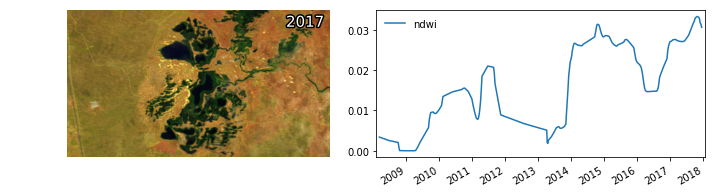

In [17]:
DEAPlotting.animated_timeseriesline(ds=data_median, df = ndwi_df,
                            output_path='{}_simple_true.mp4'.format(study_area), 
                            bands=['swir1', 'nir', 'green'], 
                            title=data_median.time.dt.year.values.tolist(),
                            show_date = False,
                            interval=200, 
                            width_pixels=1200,
                            reflect_stand=5000)